# MODEL STUDY

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

In [33]:
data = pd.read_csv("output.csv")
data['similar'] = data['similar'].apply(lambda x: x.split('/'))
data['artist_terms'] = data['artist_terms'].apply(lambda x: str(x).split('/'))
data['artist_terms_weights'] = data['artist_terms_weights'].apply(lambda x: str(x).split('/'))

l_max = data['loudness'].max()
l_min = data['loudness'].min()

t_max = data['tempo'].max()
t_min = data['tempo'].min()

data['tempo'] = (data['tempo'] - t_min)/(t_max - t_min)
data['loudness'] = (data['loudness'] - l_min)/(l_max - l_min)

In [36]:
def build_df(input: list, df: pd.core.frame.DataFrame):
    input_songs = [x.upper() for x in input]

    indexes = []
    result = []
    for i in range(len(df)):
        if str(df.iloc[i]['title']).upper() in input_songs:
            result.append(df.iloc[i])
            indexes.append(i)
    for i in indexes:
        df.drop(i, inplace=True)
    return result
    

In [93]:
print(data.iloc[0])

playlist = [data.iloc[i] for i in range(10)]
print(playlist)
songrec = data.iloc[0]

artist_name                                                        Casual
title                                                    I Didn't Mean To
release                                                       Fear Itself
similar                 [ARV4KO21187FB38008, ARWHM281187FB3D381, ARJGO...
hottness                                                         0.401998
artist_terms            [hip hop, underground rap, g funk, alternative...
artist_terms_weights    [1.0, 0.8979359555142553, 0.8842618474718359, ...
loudness                                                         0.774694
tempo                                                            0.350792
Name: 0, dtype: object
[artist_name                                                        Casual
title                                                    I Didn't Mean To
release                                                       Fear Itself
similar                 [ARV4KO21187FB38008, ARWHM281187FB3D381, ARJGO...
hottness      

In [94]:
def distance(song1, song2, alphas = [1,1,1,1,1], term = None):
    """
    song1, song2 : python native lists    format : [artist, title, album, similar, hottness, terms, terms-weights, loudness, tempo]
    alphas : python native list
    
    """
    
    alpha_hot, alpha_loud, alpha_tempo, alpha_similar, alpha_terms = alphas
    artist, title1, album1, similar1, hot1, terms1, weights1, loud1, tempo1 = song1
    artist2, title2, album2, similar2, hot2, terms2, weights2, loud2, tempo2 = song2
    
    if term == 'hot':
        return alpha_hot*abs(hot1-hot2)
    elif term == 'loud':
        return alpha_loud*abs(loud1-loud2)
    elif term == 'tempo':
        return alpha_tempo*abs(tempo1-tempo2)
    elif term == 'similar_artists':
        return alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100)
    #similar artists
    elif term == 'shared_terms':
        shared_terms = [term for term in terms1 if (term in terms2 and term != '')]
        shared_weights1, shared_weights2 = [float(weights1[terms1.index(term)]) for term in shared_terms], [float(weights2[terms2.index(term)]) for term in shared_terms]
        return alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])
    else:
        shared_terms = [term for term in terms1 if (term in terms2 and term != '')]
        shared_weights1, shared_weights2 = [float(weights1[terms1.index(term)]) for term in shared_terms], [float(weights2[terms2.index(term)]) for term in shared_terms]
        artist_terms_weighted = alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])
      
        distance = alpha_hot*abs(hot1-hot2) + alpha_loud*abs(loud1-loud2) + alpha_tempo*abs(tempo1-tempo2)
        distance += alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100)
        distance -= alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])

        return distance
    #print("hot: " + str(alpha_hot*abs(hot1-hot2) )+ " loud: " + str(alpha_loud*abs(loud1-loud2)) + " tempo: ", + str(alpha_tempo*abs(tempo1-tempo2) )+ "similar: " + 
    #str(alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100))+ "terms: " + str(alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])))

print(distance(songrec, data.iloc[1], [1,1,1,1,1], 'hot'))

0.015502101606694796


# CLUSTERING MODEL

In [97]:
k = 3 #number of clusters

#distance would be our defined distance function

def dtos(song, playlist): #distance to other songs (sum of distances to all songs in the playlist
    return np.sum([distance(othersong, song) for othersong in playlist])
    
def find_starting_points(playlist, k):
    all_distances = np.array([dtos(song, playlist) for song in playlist])
    sort_indices = np.argsort(all_distances)
    starting_points = sort_indices[:k]
    return starting_points

#print(find_starting_points(playlist,4))
#print(playlist[3])
#print(songrec)
#print(distance(playlist[3], songrec))

def cluster_songs(starting_points, k, pl, song):
    #cluster songs in input playlist into k clusters with respective starting points in starting_points wrt distance to song
    # where song is a recommended song
    # pl is playlist
    names = [[pl[start]['title']] for start in starting_points]
    values = [[distance(pl[start], song)] for start in starting_points]

    #print(res)#initialize array of k arrays each representing one cluster
    for plsong in pl[0:]:
        cluster = np.argsort(np.array([distance(plsong, pl[start]) for start in starting_points]))[0]
        print(cluster)
        #returns index in starting_points which cluster it corresponds to
        names[cluster].append(plsong['title'])
        values[cluster].append(distance(plsong, pl[cluster]))
    
    return names, values
r = cluster_songs(find_starting_points(playlist, 4), 4, playlist, songrec)
print(r)

0
1
3
1
0
0
2
0
3
2
([['Face the Ashes', "I Didn't Mean To", 'Face the Ashes', 'The Moon And I (Ordinary Day Album Version)', 'Drop of Rain'], ['Something Girls', 'Soul Deep', 'Something Girls'], ['Insatiable (Instrumental Version)', 'Keepin It Real (Skit)', 'Insatiable (Instrumental Version)'], ['Pink World', 'Amor De Cabaret', 'Pink World']], [[-2.084503512943951, -9.854782667612026, -2.084503512943951, 1.2539055040354676, 1.2371586604773], [-1.19104819878307, -10.327012725878584, -2.1902929644805065], [-0.5161540970439424, 1.2618854578958216, 1.1797418265931099], [0.3281402817450563, 1.1868898245975303, -2.984192436642349]])


# CLOSEST N SONGS IN DISTANCE

In [100]:
def closest_n(song, pl, n):
    #song is a recommended song
    #pl playlist from which song was recommended
    #returns closest n songs in an array, closest to furthest

    distances = np.array([distance(song, plsong) for plsong in pl])
    sort_distances = np.argsort(distances)
    n_indices = sort_distances[:n]
    return [playlist[i]['title'] for i in n_indices]

print(closest_n(songrec, playlist, 3))
    

["I Didn't Mean To", 'Face the Ashes', 'Something Girls']


# Cool bar graph with different components

In [101]:
def bar_graph_data(songrec, pl, alphas = [1,1,1,1,1]):
    hottness = [distance(songrec, song, alphas, 'hot') for song in pl]
    loudness = [distance(songrec, song, alphas, 'loud') for song in pl]
    tempo = [distance(songrec, song, alphas, 'tempo') for song in pl]
    similar_artists = [distance(songrec, song, alphas, 'similar_artists') for song in pl]
    shared_terms = [distance(songrec, song, alphas, 'shared_terms') for song in pl]

    return hottness, loudness, tempo, similar_artists, shared_terms

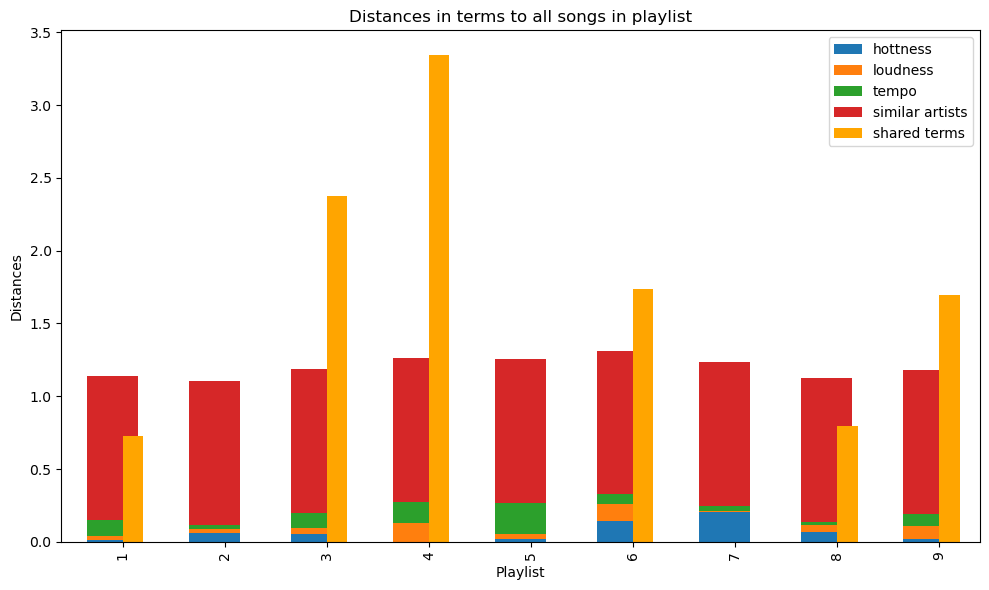

In [109]:

#DATA

# define songrec
# define playlist
alphas = [1,1,1,1,1]

hottness, loudness, tempo, similar_artists, shared_terms = bar_graph_data(songrec, playlist, alphas)
names = []
for song in playlist:
    names.append(song['title'])
data = {
    'Playlist songs' : [1,2,3,4,5,6,7,8,9],
    'hottness' : hottness[1:],
    'loudness' : loudness[1:],
    'tempo' : tempo[1:],
    'similar artists' : similar_artists[1:],
    'shared terms' : shared_terms[1:] #side bar plot
}

df = pd.DataFrame(data)

# Set 'Year' as the index
df.set_index('Playlist songs', inplace=True)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the main stacked bars
df[['hottness', 'loudness', 'tempo', 'similar artists']].plot(kind='bar', stacked=True, ax=ax)

# Manually add the separate bar next to each group
bar_width = 0.2
x = np.arange(len(df.index))  # the label locations
separate_bar_x = x + bar_width  # position for the separate bar

ax.bar(separate_bar_x, df['shared terms'], width=bar_width, label='shared terms', color='orange')

# Adding labels and title
ax.set_xlabel('Playlist')
ax.set_ylabel('Distances')
ax.set_title('Distances in terms to all songs in playlist')

# Setting x-ticks to be in the middle of the main and separate bars
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.index)

# Adding a legend
ax.legend()

# Adjust layout to make room for the separate bars
plt.tight_layout()

# Show plot
plt.show()
    